# Performance Figure
This notebook collects results from different GCN Multi-Omics trainings as well as HotNet2 and MutSigCV. It then shows the performance of all those methods as a scatterplot.
Each method in this plot represents a point and its coordinates represent the performance of it.
The x-axis depicts the performance on the known cancer genes (training + set set for GCN) and the y-axis depicts the performance on the candidate cancer genes from the NCG.

**Different metrics can be chosen to measure the performance. Currently, precision, recall and AUPR can be used.**

Metrics:

* Precision measures the fraction of cancer genes out of all genes that were predicted by the algorithm
* Recall measures the fraction of cancer genes that were found (out of all the cancer genes)
* AUPR measures the area under the precision recall curve, so it incorporates both scores

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
import seaborn as sns
import os, sys
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score
import gcnIO
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [171]:
def _get_training_data(training_dir):
    args, data_file = gcnIO.load_hyper_params(training_dir)
    if os.path.isdir(data_file): # FIXME: This is hacky and not guaranteed to work at all!
        network_name = None
        for f in os.listdir(data_file):
            if network_name is None:
                network_name = f.split('_')[0].upper()
            else:
                assert (f.split('_')[0].upper() == network_name)
        fname = '{}_{}.h5'.format(network_name, training_dir.strip('/').split('/')[-1])
        data_file = os.path.join(data_file, fname)
    data = gcnIO.load_hdf_data(data_file)
    return data

def _get_optimal_cutoff(pred, node_names, test_mask, y_test):
    pred_test = pred[pred.Name.isin(node_names[test_mask, 1])]
    y_true = pred_test.label
    y_score = pred_test.Mean_Pred
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    pr = pr[1:]
    rec = rec[1:]
    thresholds = thresholds[1:]
    distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([rec, pr]).T)**2, axis=1))
    idx = np.argmin(distances)
    best_threshold = thresholds[idx]
    return best_threshold

def _get_predictions(train_dir):
    pred_file = os.path.join(train_dir, 'ensemble_predictions.tsv')
    if os.path.isfile(pred_file):
        pred = pd.read_csv(pred_file, sep='\t')
        return pred
    else:
        return None

def _get_metric_score(pred, node_names, knowns, candidates, cutoff, metric='recall'):
    predicted_genes = pred[pred.Mean_Pred >= cutoff]
    y_knowns = pred.Name.isin(knowns)
    y_candidates = pred.Name.isin(candidates)
    if metric.upper() == 'RECALL':
        rec_known = recall_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_knowns)
        rec_cand = recall_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_candidates)
        return rec_known, rec_cand
    elif metric.upper() == 'PRECISION':
        prec_known = precision_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_knowns)
        prec_cand = precision_score(y_pred=pred.Mean_Pred >= cutoff, y_true=y_candidates)
        return prec_known, prec_cand
    elif metric.upper() == 'AUPR':
        aupr_known = average_precision_score(y_score=pred.Mean_Pred, y_true=y_knowns)
        aupr_cand = average_precision_score(y_score=pred.Mean_Pred, y_true=y_candidates)
        return aupr_known, aupr_cand
    
def get_metrics_for_training(data_dir, metric='recall'):
    precision_scores_knowns = []
    precision_scores_candidates = []
    data_types = []
    for d in os.listdir(data_dir):
        training_dir = os.path.join(data_dir, d)
        if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
            data = _get_training_data(training_dir)
            network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
            pred = _get_predictions(training_dir)
            cutoff = _get_optimal_cutoff(pred, node_names, test_mask, y_test)
            knowns, candidates = get_cancer_genes_for_net(training_dir)
            precision_known, precision_candidates = _get_metric_score(pred, node_names, knowns, candidates, cutoff, metric)
            precision_scores_knowns.append(precision_known)
            precision_scores_candidates.append(precision_candidates)
            data_types.append(d)
    return precision_scores_knowns, precision_scores_candidates, data_types
            

def get_cancer_genes_for_net(model_dir):
    data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    nodes['label'] = np.logical_or(np.logical_or(y_train, y_test), y_val)

    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])
    known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
    candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name
    return known_cancer_genes_innet, candidate_cancer_genes_innet


def get_metric_for_mutsigcv(model_dir, metric='recall'):
    # get the basic data
    data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # get the MutSigCV scores
    mutsigcv_scores = pd.read_csv('../data/pancancer/mutsigcv/mutsigcv_genescores.csv',
                                  index_col=0, sep='\t').max(axis=1)
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    mutsigcv_scores_filled = mutsigcv_scores.reindex(nodes.Name).fillna(0)
    mutsigcv_df = pd.DataFrame(mutsigcv_scores_filled, columns=['Mean_Pred'])
    mutsigcv_df['Name'] = mutsigcv_df.index
    mutsigcv_df['label'] = y_test
    # get known and candidate cancer genes
    knowns, candidates = get_cancer_genes_for_net(model_dir)
    # get cutoff
    cutoff = _get_optimal_cutoff(mutsigcv_df, node_names, test_mask, y_test)
    # compute metric
    return _get_metric_score(mutsigcv_df, node_names, knowns, candidates, cutoff, metric)

def get_hotnet2_results():
    hotnet2_results = {}
    with open('../data/pancancer/hotnet2/hotnet2_results/hotnet2_subnetworks.csv', 'r') as f:
        current_network = None
        current_datatype = None
        all_genes_current = []
        counter = 0
        for line in f.readlines():
            if line.split('\t')[0] in ['HINT+HI2012', 'iRefIndex', 'Multinet']:
                if current_network is None or len(all_genes_current) == 0:
                    pass
                else:
                    hotnet2_results['{}_{}'.format(current_network, current_datatype)] = list(set(all_genes_current))
                current_network = line.split('\t')[0]
                current_datatype = line.split('\t')[1]
                all_genes_current = []
            if current_network is None:
                continue
            genes = [i.strip() for i in line.split('\t')[2:] if not i in ['', '\n']]
            all_genes_current += genes
        hotnet2_results['{}_{}'.format(current_network, current_datatype)] = list(set(all_genes_current))
    return hotnet2_results

def compute_hotnet2_metrics(metric='recall'):
    collected = []
    datatypes = []
    networks = []
    hotnet2_results = get_hotnet2_results()
    for key in hotnet2_results:
        res_df = pd.DataFrame(hotnet2_results[key], columns=['Name'])
        res_df['Mean_Pred'] = 1
        if key.split('_')[0] == 'Multinet':
            data_dir = dir_multinet
            net = 'Multinet'
        elif key.split('_')[0] == 'iRefIndex':
            data_dir = dir_iref
            net = 'IREF'
        else:
            continue
        data = _get_training_data(os.path.join(data_dir, 'multiomics'))
        knowns, candidates = get_cancer_genes_for_net(os.path.join(data_dir, 'multiomics'))
        network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
        nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
        res_df_hotnet2 = res_df.set_index('Name').reindex(nodes.Name).fillna(0)
        res_df_hotnet2['Name'] = res_df_hotnet2.index
        collected.append(_get_metric_score(res_df_hotnet2, node_names, knowns, candidates, 0.5, metric=metric))
        datatype = 'Hotnet2 ({} Scores)'.format(key.split('_')[1])
        datatypes.append(datatype)
        networks.append(net)
    result = pd.DataFrame(collected, index=datatypes, columns=['Known Cancer Genes', 'Candidate Cancer Genes'])
    result['Method'] = datatypes
    result['Network'] = networks
    return result

In [172]:
dir_multinet = '../data/GCN/training/all_multiomics_multinet/'
dir_cpdb = '../data/GCN/training/all_multiomics_CPDB/'
dir_iref = '../data/GCN/training/all_multiomics_IREF/'
dir_mutsigscores = '../data/GCN/training/all_multiomics_IREF_mutsigcvscores/'
dir_withcna = '../data/GCN/training/all_multiomics_IREF_withCNA/'
training_runs = {'Multinet': dir_multinet, 'CPDB': dir_cpdb,
                 'IREF':dir_iref, 'IREF (MutSigCV)': dir_mutsigscores,
                 'IREF (CNA included)': dir_withcna
                }

## Plot metrics for multiple trainings in one figure

In [178]:
metric_of_choice = 'precision'

# get metrics from different multi-omics trainings
all_metrics = []
for network_name in training_runs:
    print (network_name)
    metric_known, metric_candidates, omics = get_metrics_for_training(training_runs[network_name], metric=metric_of_choice)
    x = pd.DataFrame([metric_known, metric_candidates], columns=omics, index=['Known Cancer Genes', 'Candidate Cancer Genes']).T
    x['Network'] = network_name
    all_metrics.append(x)
all_metrics_df = pd.concat(all_metrics)
all_metrics_df['Method'] = all_metrics_df.index

# get mutsigcv metrics
mutsigcv_perf = []
for network_name, network_dir in {'Multinet': dir_multinet, 'CPDB': dir_cpdb, 'IREF':dir_iref}.items():
    ms_perf_known, ms_perf_cand = get_metric_for_mutsigcv(os.path.join(network_dir, 'multiomics'), metric=metric_of_choice)
    mutsigcv_perf.append([ms_perf_known, ms_perf_cand, network_name])
mutsig_perf_df = pd.DataFrame(mutsigcv_perf, columns=['Known Cancer Genes', 'Candidate Cancer Genes', 'Network'])
mutsig_perf_df.set_index('Network', inplace=True)
mutsig_perf_df['Method'] = 'MutSigCV'
mutsig_perf_df['Network'] = mutsig_perf_df.index

# compute metrics for HotNet2 results
hotnet2_perf = compute_hotnet2_metrics(metric=metric_of_choice)

all_metrics_df = pd.concat((all_metrics_df, mutsig_perf_df, hotnet2_perf))

Multinet
CPDB
IREF
IREF (MutSigCV)
IREF (CNA included)
HINT+HI2012_Frequency
HINT+HI2012_MutSig
iRefIndex_Frequency
iRefIndex_MutSig
Multinet_Frequency
Multinet_MutSig


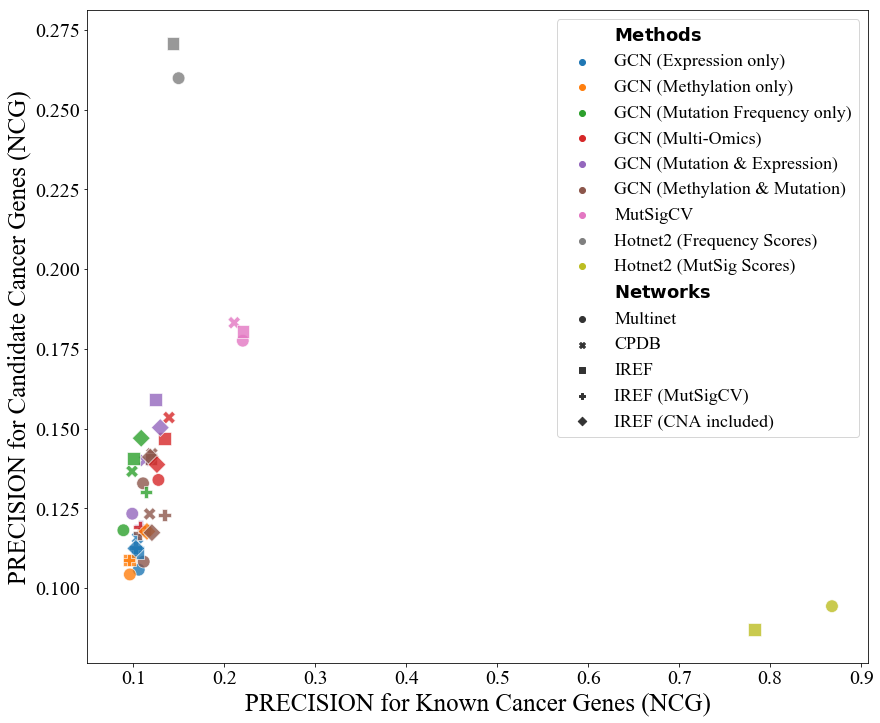

In [179]:
fig = plt.figure(figsize=(14, 12))
replace_dict = {'expression': 'GCN (Expression only)', 'methylation': 'GCN (Methylation only)',
                'mutations': 'GCN (Mutation Frequency only)', 'multiomics': 'GCN (Multi-Omics)',
                'mutation_expression': 'GCN (Mutation & Expression)',
                'methylation_expression': 'GCN (Methylation & Mutation)',
                'methylation_mutation': 'GCN (Methylation & Mutation)'
               }
all_metrics_df.Method = all_metrics_df.Method.replace(replace_dict)
sns.scatterplot(data=all_metrics_df, x='Known Cancer Genes', y='Candidate Cancer Genes', hue='Method', style='Network', alpha=.8, s=160)
plt.xlabel('{} for Known Cancer Genes (NCG)'.format(metric_of_choice.upper()), fontsize=25)
plt.ylabel('{} for Candidate Cancer Genes (NCG)'.format(metric_of_choice.upper()), fontsize=25)
plt.tick_params(axis='both', labelsize=20)
legend = plt.legend(prop={'size': 18})
legend.texts[0].set_text(r"$\bf{Methods}$")
legend.texts[all_metrics_df.Method.nunique()+1].set_text(r"$\bf{Networks}$")
fig.savefig('../data/pancancer/ensemble_metrics_{}.svg'.format(metric_of_choice))